In [1]:
import numpy as np
import pandas as pd
from scipy.linalg import lu ,qr as qrs, cholesky, lu_factor, lu_solve
from numpy.linalg import qr, cholesky as chol_num , inv, eig
from scipy.sparse import csc_matrix, linalg as sla
from scipy.sparse.linalg import SuperLU
from scipy.linalg.interpolative import interp_decomp,reconstruct_matrix_from_id, reconstruct_skel_matrix
import psutil
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
np.random.seed(5)


In [2]:

def time_func(func, n_trials, *args, **kwargs):
    times = []
    for i in range(n_trials):
        t0 = time()
        res = func(*args, **kwargs)
        tt = time()
        t = tt - t0
        times.append(t)
    return np.asarray(times)

def time_funcs(funcs, Ns=[200, 500, 1000, 2000], n_trials=4):
    results = []
    for N in Ns:
        X=np.random.rand(N,N)
        for func in funcs:
            times = time_func(func, n_trials, X)
            
            results.extend([{
                'time': t, 
                'N': N,
                'func_name': func.__name__,
                } for t in times])
    return pd.DataFrame(results)

In [3]:
# time_qr= time_funcs([qr_numpy,qr_scipy], Ns=[100,500,1000, 5000], n_trials=5)
# time_cholesky=time_funcs([cholesky_num,cholesky_scipy],Ns=[100,500,1000,5000], n_trials=5)

In [4]:
def memory_func(func, n_trials,X):
    memory = []
    for i in range(n_trials):
        tmp = memory_usage((func, (X,)))
        memory.append(max(tmp))
    return np.asarray(memory)
def memory_funcs(funcs, Ns=[200, 500, 1000, 2000], n_trials=4):
    results = []
    for N in Ns:
        X=np.random.rand(N,N)
        for func in funcs:
            t4 = memory_func(func, n_trials, X)
            results.extend([{
                'memory': t, 
                'N': N,
                'func_name': func.__name__,
                } for t in t4])
    return pd.DataFrame(results)

# LU Decomp

In [5]:
def lu_decomp(a):
    b=np.dot(a,a.T)
    p,l,u = lu(b)
    return p,l,u

# Gaussian LU

In [6]:
a = np.random.rand(100,100)
lu_fac, piv = lu_factor(a)
b=np.random.randint(1,10,(100,1)) #RHS
sol=lu_solve((lu_fac,piv),b)

In [7]:
sol.shape

(100, 1)

# QR 

In [8]:
def qr_scipy(x):
    return qrs(x)
def qr_numpy(x):
    return qr(x)

In [9]:
ram_iniitial = psutil.virtual_memory().used
a= np.random.rand(1000,1000)

In [10]:
q,r=qr(a)
ram_final = psutil.virtual_memory().used
print("ram used is", ram_final-ram_iniitial)
print(psutil.Process(os.getpid()).memory_info().rss / 1024 ** 2)

ram used is 28438528
156.99609375


In [11]:
a1=q*r
print('Error is {}'.format(sum(np.ravel(a-a1))))

Error is 500444.8357083268


In [12]:
q.shape

(1000, 1000)

In [13]:
r2_score(a,a1)

-3.017349175015904

# Cholesky

In [14]:
def cholesky_num(x):
    x=np.dot(x,x.T)
    return chol_num(x)
def cholesky_scipy(x):
    x=np.dot(x,x.T)
    return cholesky(x)

In [15]:
a= np.random.rand(100,100)
a= np.dot(a,a.T)

In [16]:
b = cholesky(a)

In [17]:
b.shape

(100, 100)

In [18]:
a1= np.dot(b,np.matrix.getH(b)) # reconstruction ( conjugate transpose)

In [19]:
r2_score(a,a1)

-307.7383431512959

# Super LU (Sparse LU)

In [20]:
a = csc_matrix([[1.6,2.78,0.23,4.456],[1.356,0.24,0.56,1.243],[1.234,0.435,2.545,1.45],[2.45,2.455,1.45,0.45]])

In [21]:
lus = sla.splu(a)

In [22]:
b = np.array([1, 2, 3, 4])

In [23]:
x = lus.solve(b) #RHS of equation

In [24]:
a.dot(x)


array([1., 2., 3., 4.])

In [25]:
Pr = csc_matrix((np.ones(4), (lus.perm_r, np.arange(4))))
Pc = csc_matrix((np.ones(4), (np.arange(4), lus.perm_c))) #PErmuations

In [26]:
a22=(Pr.T * (lus.L * lus.U) * Pc.T).A

In [27]:
mean_squared_error(a.toarray(),a22)

6.403717065087559e-33

# RRQR

In [28]:
a=np.random.randint(100,size=(100,100))
a.shape

(100, 100)

In [29]:
q,r, p = qrs(a,pivoting=True) 

In [30]:
#temp=np.dot(np.dot(q,r),np.linalg.inv(p))
print(sum(np.ravel(a-np.dot(q,r))))

1.2721557141048834e-10


In [31]:
#sum(np.ravel(a-))

In [32]:
def lu_decomp(n_trials , x):
    error=[]
    for i in range(n_trials):
        l=[]
        to=time()
        b=np.dot(x,x.T)
        p,l,u = lu(b)
        t1=time()
        a1 = np.dot(l,u)
        l.append(mean_absolute_error(x,a1))
        l.append(mean_squared_error(x,a1))
        l.append(r2_score(x,a1))
        l.append(t1-t0)
        error.append(l)
    return np.asarray(error)
def lu_final(Ns=[100,200,500,1000,2000, 5000], n_trials=5):
    res=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score','Time', 'N',"Func Name"])
    for i in Ns:
        x=np.random.rand(i,i)
        #print(type(x))
        errs = rrqr(n_trials,x)
        for k in errs:
            res.loc[len(res.index)]=(k[0],k[1],k[2],k[3],i,'LU')
    return res

    

In [33]:
def rrqr(n_trials, x):
    #print(x.shape)
    error=[]
    for i in range(n_trials):
        l=[]
        t0=time()
        q,r,p = qrs(x,pivoting=True)
        t1=time()
        a1 = np.dot(q,r)
        l.append(mean_absolute_error(x,a1))
        l.append(mean_squared_error(x,a1))
        l.append(r2_score(x,a1))
        l.append(t1-t0)
        error.append(l)
    return np.asarray(error)
def rrqr_final(Ns=[100,200,500,1000,2000, 5000], n_trials=5):
    res=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score','Time', 'N',"Func Name"])
    for i in Ns:
        x=np.random.rand(i,i)
        #print(type(x))
        errs = rrqr(n_trials,x)
        for k in errs:
            res.loc[len(res.index)]=(k[0],k[1],k[2],k[3],i,'RRQR')
    return res


In [34]:
np.dot(q,r).shape

(100, 100)

# Interpolative Decomposition

In [35]:
def interpol(x, n_trials):
    error=[]
    for  i in range(n_trials):
        l=[]
        t0=time()
        k,idx,proj = interp_decomp(x, 0.7)
        t1=time()
        a1=reconstruct_matrix_from_id(reconstruct_skel_matrix(x,k,idx),idx,proj)
        l.append(mean_absolute_error(x,a1))
        l.append(mean_squared_error(x,a1))
        l.append(r2_score(x,a1))
        l.append(t1-t0)
        error.append(l)
    return np.asarray(error)
def inter_final(Ns=[100,200,500,1000,2000, 5000], n_trials=5):
    res=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score','Time', 'N',"Func Name"])
    for i in Ns:
        x=np.random.rand(i,i)
        errs = interpol(x,n_trials)
        for k in errs:
            res.loc[len(res.index)]=(k[0],k[1],k[2],k[3],i,"Interpolative")
    return res


In [36]:
a =np.random.rand(100,100)

In [37]:
k,idx,proj = interp_decomp(a, 0.7)

In [38]:
b=reconstruct_matrix_from_id(reconstruct_skel_matrix(a,k,idx),idx,proj)

# EigenDecomposition

In [39]:

def eig_error(x, n_trials):
    """ x, n_trials"""
    error=[]
    for i in range(n_trials):
        l=[]
        t0=time()
        eigenvalues, eigenvector= eig(x)
        lamb= np.diag(eigenvalues)
        t1=time()
        a1= np.dot(np.dot(eigenvector,lamb),np.linalg.inv(eigenvector))
        l.append(mean_absolute_error(x,np.absolute(a1)))
        l.append(mean_squared_error(x,np.absolute(a1)))
        l.append(r2_score(x,np.absolute(a1)))
        l.append(t1-t0)
        error.append(l)
    return np.asarray(error)

def eig_final(Ns=[100,200,500,1000,2000, 5000], n_trials=5):
    res=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score','Time', 'N',"Func Name"])
    for i in Ns:
        print(i)
        x=np.random.rand(i,i)
        errs = eig_error(x,n_trials)
        for k in errs:
            res.loc[len(res.index)]=(k[0],k[1],k[2],k[3],i,"Eigen")
    return res
    


In [40]:
#eig_final()

In [41]:
a = np.random.rand(100,100)

In [42]:
eigenvalues, eigenvector= eig(a)

In [43]:
lamb= np.diag(eigenvalues)

In [44]:
#so decompoostion is eigenvector*lamb*eigenvector^-1

In [45]:
np.dot(np.dot(eigenvector,lamb),np.linalg.inv(eigenvector)).shape

(100, 100)

# Error

In [46]:

def time_func(func, n_trials, *args, **kwargs):
    times = []
    for i in range(n_trials):
        t0 = time()
        res = func(*args, **kwargs)
        tt = time()
        t = tt - t0
        times.append(t)
    return np.asarray(times)

def time_funcs(funcs, Ns=[200, 500, 1000, 2000], n_trials=4):
    results = []
    for N in Ns:
        X=np.random.rand(N,N)
        for func in funcs:
            times = time_func(func, n_trials, X)
            
            results.extend([{
                'time': t, 
                'N': N,
                'func_name': func.__name__,
                } for t in times])
    return pd.DataFrame(results)

In [47]:
def cholesky_error(func, n_trials, x ):
    error=[]

    for i in range(n_trials):
        t0=time()
        a=func(x)
        tt=time()
        l=[]
        a1=np.dot(a,np.matrix.getH(a))
        l.append(mean_absolute_error(x,a1))
        l.append(mean_squared_error(x,a1))
        l.append(r2_score(x,a1))
        l.append(tt-t0)
        error.append(l)
    return np.asarray(error)

def cholesky_all(funcs, Ns, n_trials):
    res=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score','Time', 'N',"Func Name"])
    for i in Ns:
        x=np.random.rand(i,i)
        for func in funcs:
            errors=cholesky_error(func,n_trials, x)
            for k in errors:
                res.loc[len(res.index)]=(k[0],k[1],k[2],k[3],i,func.__name__)

    return res


        
#a1= np.dot(b,np.matrix.getH(b)) # reconstruction ( conjugate transpose)

In [48]:
err_chol=cholesky_all([cholesky_num,cholesky_scipy], Ns=[100,200,300,400,500,600,700,800,900,1000],n_trials=5 )

In [49]:
def qr_error(func, n_trials, x ):
    error=[]

    for i in range(n_trials):
        t0=time()
        q,r=func(x)
        t1=time()
        l=[]
        a1=np.dot(q,r)
        l.append(mean_absolute_error(x,a1))
        l.append(mean_squared_error(x,a1))
        l.append(r2_score(x,a1))
        l.append(t1-t0)
        error.append(l)
    return np.asarray(error)

def qr_all(funcs, Ns, n_trials):
    res=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score','Time', 'N',"Func Name"])
    for i in Ns:
        x=np.random.rand(i,i)
        for func in funcs:
            errors=qr_error(func,n_trials, x)
            for k in errors:
                res.loc[len(res.index)]=(k[0],k[1],k[2],k[3],i,func.__name__)

    return res


In [50]:
err_qr=qr_all([qr_scipy,qr_numpy], Ns=[100,200,300, 400, 500, 600 , 700, 800, 900, 1000],n_trials=5 )

In [51]:
def lu_error(func, n_trials, x ):
    error=[]

    for i in range(n_trials):
        p,l,u=func(x)
        l=[]
        a1=np.dot(l,u)
        l.append(mean_absolute_error(x,a1))
        l.append(mean_squared_error(x,a1))
        #l.append(mean_squared_log_error(x,a1))
        #l.append(median_absolute_error(y_true=x,y_pred=a1))
        l.append(r2_score(x,a1))
        error.append(l)
    return np.asarray(error)

def lu_all(func, Ns, n_trials):
    res=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score', 'N',"Func Name"])
    for i in Ns:
        x=np.random.rand(i,i)
        
        errors=lu_error(func,n_trials, x)
        for k in errors:
            res.loc[len(res.index)]=(k[0],k[1],k[2],i,func.__name__)
                # res['Mean Absolute']= k[0]
                # res['Mean Squared']=k[1]
                # res['R2-Score']=k[2]
                # res['N']= i
                # res['Func  Name']= func.__name__
    return res


        
#a1= np.dot(b,np.matrix.getH(b)) # reconstruction ( conjugate transpose)

# General Func Error

In [52]:
 err_gen=pd.DataFrame(columns=['Mean Absolute','Mean Squared','R2-Score','Time', 'N',"Func Name"])

In [53]:
err_rrqr = rrqr_final(Ns=[100,200,300,400,500,600,700,800,900,1000])
err_eig = eig_final(Ns=[100,200,300,400,500,600,700,800,900,1000])
err_interpol = inter_final(Ns=[100,200,300,400,500,600,700,800,900,1000])
err_lu=lu_final(Ns=[100,200,300,400,500,600,700,800,900,1000])
    

100
200
300
400
500
600
700
800
900
1000


In [54]:
err_gen = pd.concat([err_rrqr, err_eig, err_interpol, err_lu], axis=0)

In [55]:
re=err_gen.groupby(['Func Name' ]).agg([np.mean])

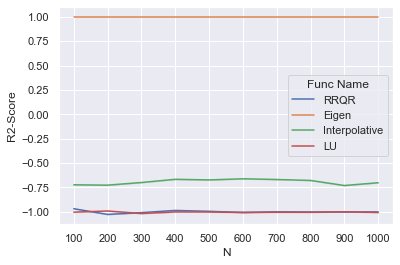

In [56]:
_,ax = plt.subplots()
sns.lineplot(x='N', y ='R2-Score', data=err_gen, hue='Func Name', ax = ax)
ax.set_xticks(np.arange(100,1100,100))

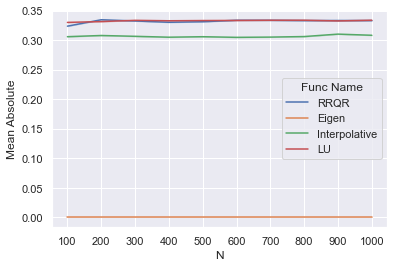

In [57]:
_,ax = plt.subplots()
sns.lineplot(x='N', y ='Mean Absolute', data=err_gen, hue='Func Name', ax = ax)
ax.set_xticks(np.arange(100,1100,100))

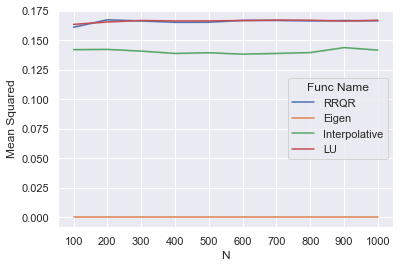

In [58]:
_,ax = plt.subplots()
sns.lineplot(x='N', y ='Mean Squared', data=err_gen, hue='Func Name', ax = ax)
ax.set_xticks(np.arange(100,1100,100))

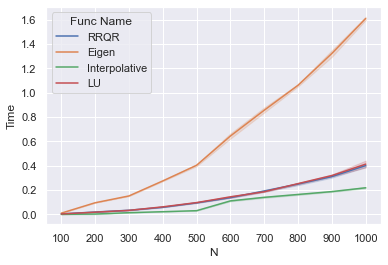

In [59]:
_,ax = plt.subplots()
sns.lineplot(x='N', y ='Time', data=err_gen, hue='Func Name', ax = ax)
ax.set_xticks(np.arange(100,1100,100))

<AxesSubplot:xlabel='N', ylabel='Mean Absolute'>

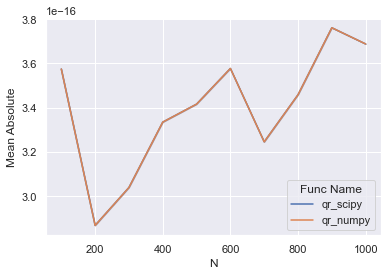

In [60]:
_,ax = plt.subplots()
sns.lineplot(x='N', y='Mean Absolute', hue='Func Name', data=err_qr, ax =ax)


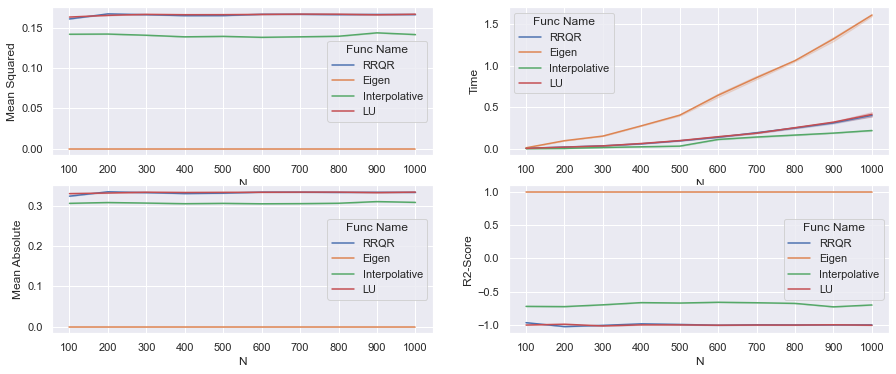

In [61]:
_,ax = plt.subplots(2,2, figsize=(15,6))
sns.lineplot(x='N', y ='Mean Squared', data=err_gen, hue='Func Name', ax = ax[0,0])
ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_gen, hue='Func Name', ax = ax[0,1])
ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Mean Absolute', data=err_gen, hue='Func Name', ax = ax[1,0])
ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='R2-Score', data=err_gen, hue='Func Name', ax = ax[1,1])
ax[1,1].set_xticks(np.arange(100,1100, 100))

In [62]:
re = err_gen.groupby(['N','Func Name']).agg(np.mean)

In [63]:
re=re.reset_index()

<AxesSubplot:xlabel='N', ylabel='R2-Score'>

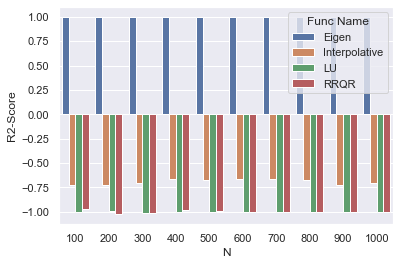

In [64]:
sns.barplot(x='N', y='R2-Score', hue= 'Func Name', data=re)

<AxesSubplot:xlabel='N', ylabel='Mean Absolute'>

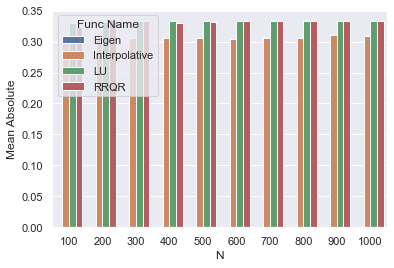

In [65]:
sns.barplot(x='N', y='Mean Absolute', hue= 'Func Name', data=re)

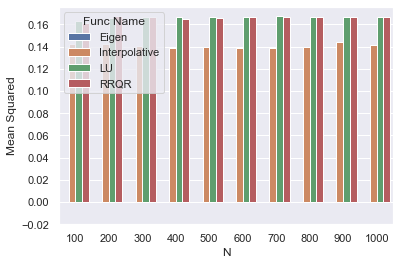

In [66]:
_,ax = plt.subplots()
sns.barplot(x='N', y='Mean Squared', hue= 'Func Name', data=re, ax=ax)
ax.set_yticks(np.arange(-0.02,0.18,0.02 ))

<AxesSubplot:xlabel='N', ylabel='Mean Absolute'>

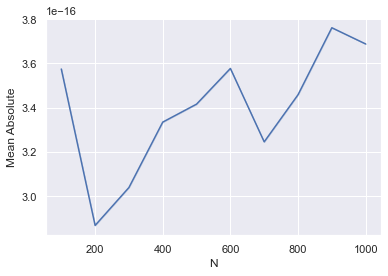

In [67]:
sns.lineplot(y='Mean Absolute', x='N', data= err_qr)

<AxesSubplot:xlabel='N', ylabel='R2-Score'>

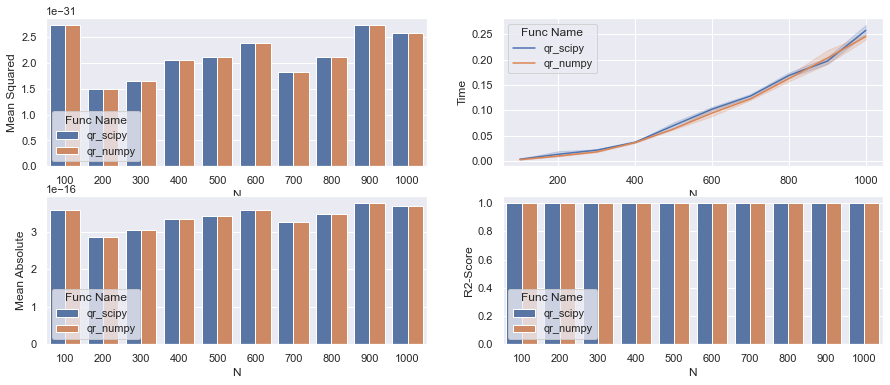

In [68]:
_,ax = plt.subplots(2,2, figsize=(15,6))
sns.barplot(x='N', y ='Mean Squared', data=err_qr, hue='Func Name', ax = ax[0,0])
#ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_qr, hue='Func Name', ax = ax[0,1])
#ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.barplot(x='N', y ='Mean Absolute', data=err_qr, hue='Func Name', ax = ax[1,0])
#ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.barplot(x='N', y ='R2-Score', data=err_qr, hue='Func Name', ax = ax[1,1])
#ax[1,1].set_xticks(np.arange(100,1100, 100))
#sns.barplot(x='N', y ='R2-Score', data=err_qr, hue='Func Name', ax = ax[1,1])

<AxesSubplot:xlabel='N', ylabel='Mean Absolute'>

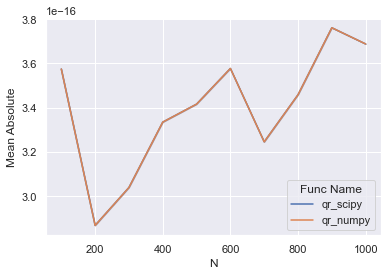

In [69]:
sns.lineplot(x='N', y ='Mean Absolute', data=err_qr, hue='Func Name')

In [70]:
te=err_qr[err_qr['Func Name']=='qr_numpy']

<AxesSubplot:xlabel='N', ylabel='Mean Absolute'>

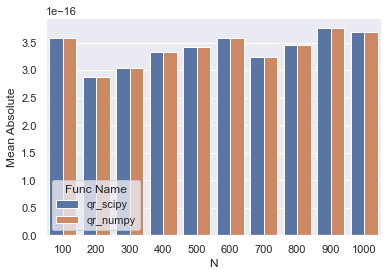

In [71]:
sns.barplot(x='N', y ='Mean Absolute', data=err_qr, hue='Func Name')

<AxesSubplot:xlabel='N', ylabel='R2-Score'>

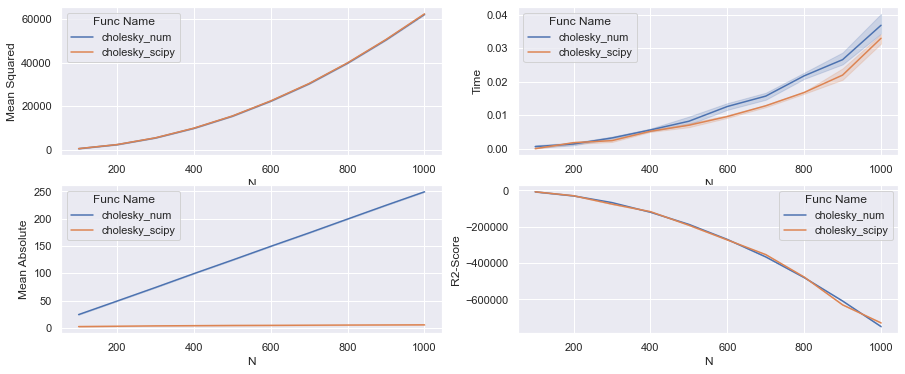

In [72]:
_,ax = plt.subplots(2,2, figsize=(15,6))
sns.lineplot(x='N', y ='Mean Squared', data=err_chol, hue='Func Name', ax = ax[0,0])
#ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_chol, hue='Func Name', ax = ax[0,1])
#ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Mean Absolute', data=err_chol, hue='Func Name', ax = ax[1,0])
#ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='R2-Score', data=err_chol, hue='Func Name', ax = ax[1,1])
#ax[1,1].set_xticks(np.arange(100,1100, 100))

## Comparative Final

In [73]:
err_gen = pd.concat([err_rrqr, err_eig, err_interpol, err_lu, err_qr, err_chol], axis=0)

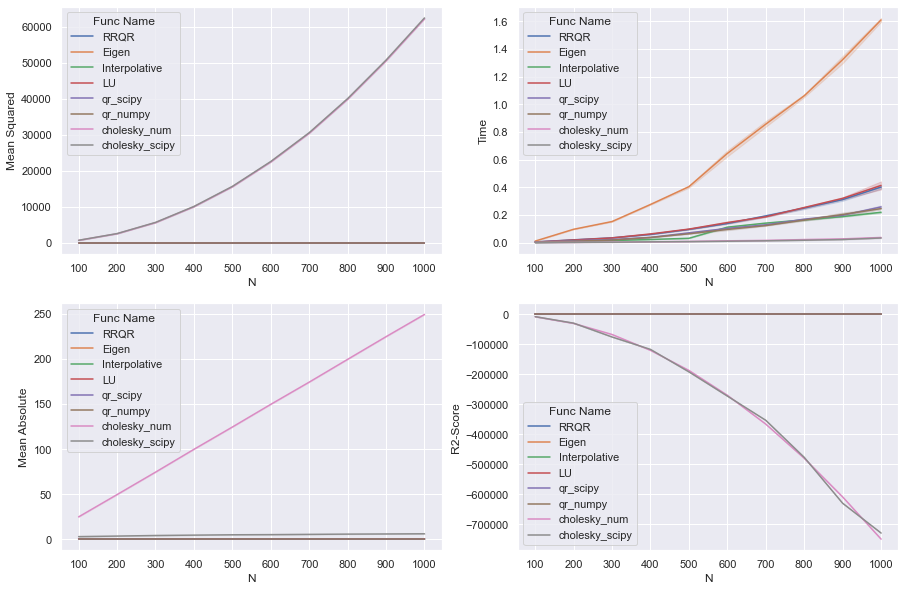

In [76]:
_,ax = plt.subplots(2,2, figsize=(15,10))
sns.lineplot(x='N', y ='Mean Squared', data=err_gen, hue='Func Name', ax = ax[0,0])
ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_gen, hue='Func Name', ax = ax[0,1])
ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Mean Absolute', data=err_gen, hue='Func Name', ax = ax[1,0])
ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='R2-Score', data=err_gen, hue='Func Name', ax = ax[1,1])
ax[1,1].set_xticks(np.arange(100,1100, 100))

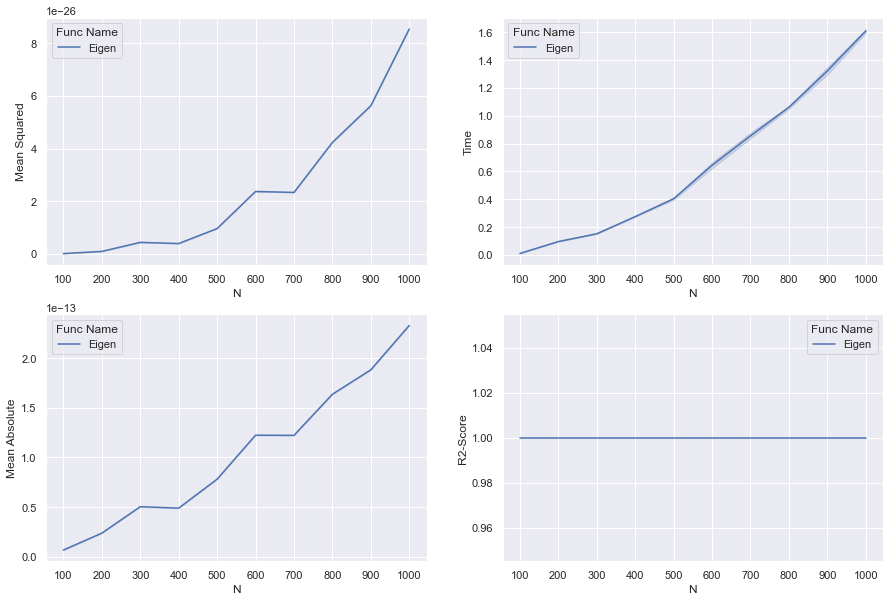

In [77]:
_,ax = plt.subplots(2,2, figsize=(15,10))
sns.lineplot(x='N', y ='Mean Squared', data=err_eig, hue='Func Name', ax = ax[0,0])
ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_eig, hue='Func Name', ax = ax[0,1])
ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Mean Absolute', data=err_eig, hue='Func Name', ax = ax[1,0])
ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='R2-Score', data=err_eig, hue='Func Name', ax = ax[1,1])
ax[1,1].set_xticks(np.arange(100,1100, 100))

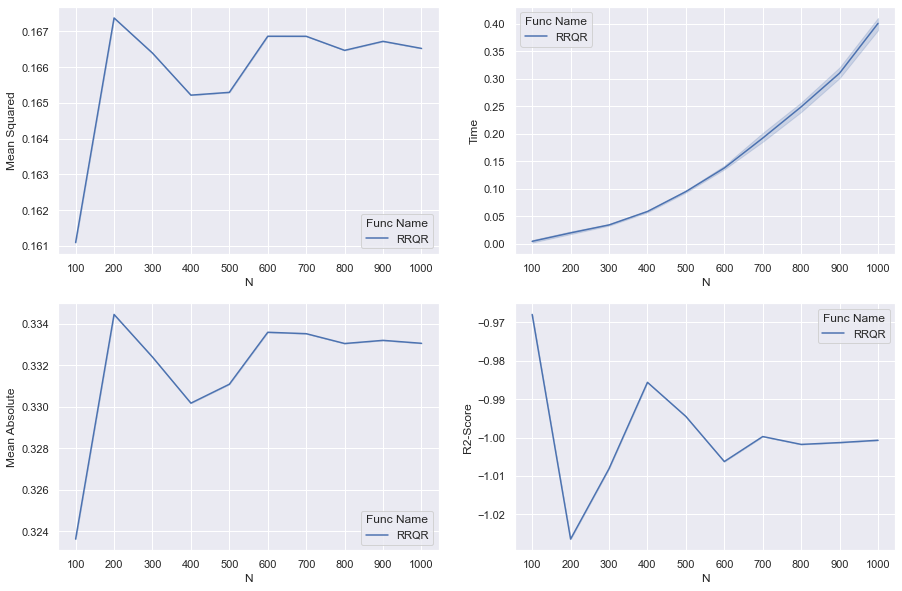

In [78]:
_,ax = plt.subplots(2,2, figsize=(15,10))
sns.lineplot(x='N', y ='Mean Squared', data=err_rrqr, hue='Func Name', ax = ax[0,0])
ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_rrqr, hue='Func Name', ax = ax[0,1])
ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Mean Absolute', data=err_rrqr, hue='Func Name', ax = ax[1,0])
ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='R2-Score', data=err_rrqr, hue='Func Name', ax = ax[1,1])
ax[1,1].set_xticks(np.arange(100,1100, 100))

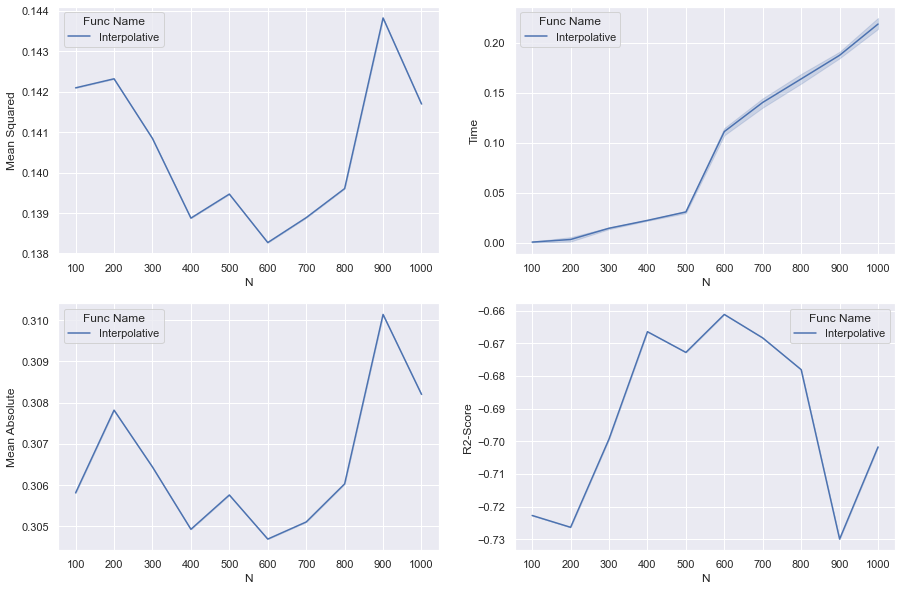

In [79]:
_,ax = plt.subplots(2,2, figsize=(15,10))
sns.lineplot(x='N', y ='Mean Squared', data=err_interpol, hue='Func Name', ax = ax[0,0])
ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_interpol, hue='Func Name', ax = ax[0,1])
ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Mean Absolute', data=err_interpol, hue='Func Name', ax = ax[1,0])
ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='R2-Score', data=err_interpol, hue='Func Name', ax = ax[1,1])
ax[1,1].set_xticks(np.arange(100,1100, 100))

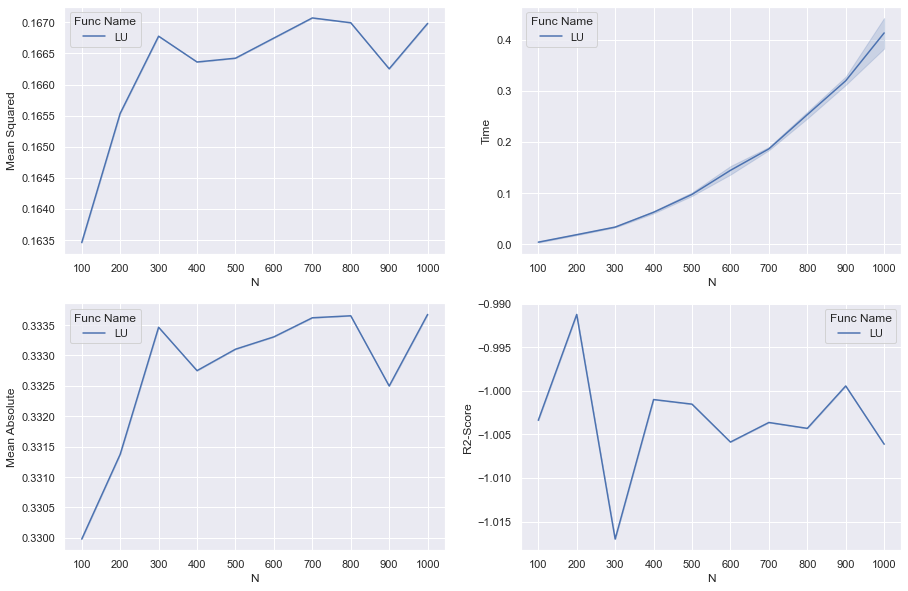

In [80]:
_,ax = plt.subplots(2,2, figsize=(15,10))
sns.lineplot(x='N', y ='Mean Squared', data=err_lu, hue='Func Name', ax = ax[0,0])
ax[0,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Time', data=err_lu, hue='Func Name', ax = ax[0,1])
ax[0,1].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='Mean Absolute', data=err_lu, hue='Func Name', ax = ax[1,0])
ax[1,0].set_xticks(np.arange(100,1100, 100))
sns.lineplot(x='N', y ='R2-Score', data=err_lu, hue='Func Name', ax = ax[1,1])
ax[1,1].set_xticks(np.arange(100,1100, 100))